# 一連の予測を行うNotebook
## ライブラリのインポート

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
from conf.config import CFG, DIRS

from utils.load_datas import load_all_datas
from utils.feature_enginerring import feature_engineering_prototype
from utils.validations import cross_val_train
from utils.lgb_trial import new_tuning_along_time

## 設定

In [ ]:
config = CFG()

# データのロード
train_df, test_df = load_all_datas()

# 変換
train_df, test_df = feature_engineering_prototype(train_df, test_df, config)

# 切り分け
X_train_pp = train_df.loc[:, config.FEATURES]
y_train = train_df.loc[:, config.TARGET]
X_test_pp = test_df.loc[:, config.FEATURES]

# パラメータの設定
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "learning_rate": 0.05,
    "max_depth": 5,
    "min_child_weight": 1.0,
    "bagging_fraction": 0.8, # subsampleと同義
    "feature_fraction": 0.8, # colsample_bytreeと同義
    "random_state": config.SEED, 
}

## 予測

In [ ]:
models, val_scores, val_preds, test_preds = new_tuning_along_time(X_train_pp, y_train, X_test_pp, params, config)

In [4]:
opt_params = models[-1].params
print(f"Best params: \n{opt_params}")

Best params: 
{'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'learning_rate': 0.05, 'max_depth': 5, 'bagging_fraction': 0.5726718533292843, 'feature_fraction': 0.9799999999999999, 'random_state': 42, 'feature_pre_filter': False, 'min_sum_hessian_in_leaf': 1.0, 'lambda_l1': 6.727805498277331e-08, 'lambda_l2': 0.12659863027136217, 'num_leaves': 31, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 3000, 'categorical_column': [0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 14]}


In [5]:
val_scores, val_preds, test_preds, model = cross_val_train(X_train_pp, y_train, X_test_pp, opt_params, config)

In [6]:
print(f"Mean RMSLE: {np.mean(val_scores):.5f}")

Mean RMSLE: 4627.03561


## 特徴量重要性

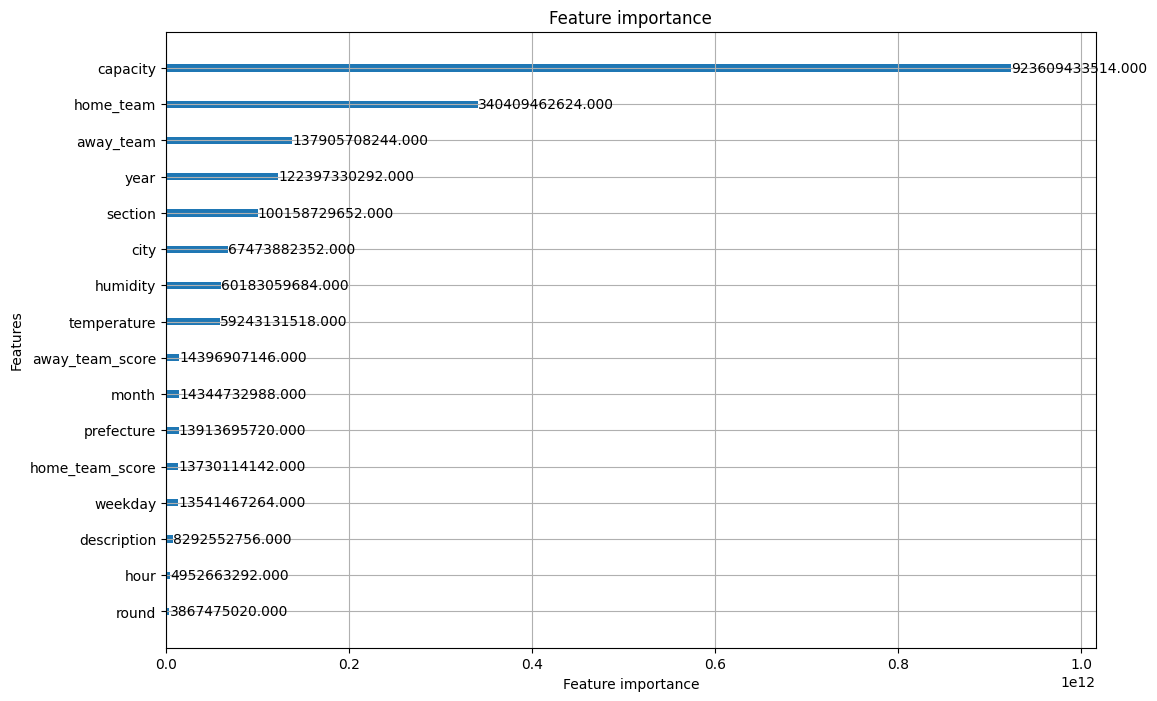

In [7]:
lgb.plot_importance(models[-1], importance_type="gain", figsize=(12, 8))
plt.show()

## submitの作成

In [11]:
test_preds = models[-1].predict(X_test_pp)

sub = pd.DataFrame({
    "id": test_df["id"],
    "attendance": test_preds,
})

sub.to_csv(os.path.join(DIRS["OUTPUT"], "submission_time_along_last_opt.csv"), index=False, header=None)